In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class quaternion:
    def __init__(self, q0, q1, q2, q3):
        self.q0 = q0
        self.q = np.array([
            q1,
            q2,
            q3
        ])
        
    def __add__(self, other):
        new_q0 = self.q0 + other.q0
        new_q = self.q + other.q
        
        return quaternion(new_q0, *new_q)
    
    def __sub__(self, other):
        new_q0 = self.q0 - other.q0
        new_q = self.q - other.q
        
        return quaternion(new_q0, *new_q)
    
    def __mul__(self, other):
        if type(other) == type(self):
            new_q0 = self.q0*other.q0 - np.inner(self.q, other.q)
            new_q = self.q0*other.q + other.q0*self.q + np.cross(self.q, other.q)
        else:
            new_q0 = self.q0*other
            new_q = self.q*other
        
        return quaternion(new_q0, *new_q)
    
    def __truediv__(self, other):
        return quaternion(self.q0/other, *(-self.q/other))
    
    def __repr__(self):
        return f"{self.q0} + {self.q[0]}i + {self.q[1]}j + {self.q[2]}k"
    
    def conjugate(self):
        return quaternion(self.q0, *(-self.q))
    
    def norm(self):
        return np.sqrt(self.q0*self.q0 + np.square(self.q).sum())
    
    def inv(self):
        return self.conjugate()/np.square(self.norm())

In [3]:
class Rotation:
    def __init__(self,in_place=False, theta=None, u=None):
        self.in_place = in_place
        
        if self.in_place:
            self.q = quaternion(np.cos(theta/2), *(np.sin(theta/2)*u))
            self.q_conjugate = self.q.conjugate()
            
        
    def __call__(self, v, theta=None, u=None):
        if not self.in_place:
            q = quaternion(np.cos(theta/2), *(np.sin(theta/2)*u))
            return q*v*q.conjugate()
        
        else:
            return self.q*v*self.q_conjugate

In [30]:
class joint_link:
    def __init__(self, theta, d, a, alpha, joint="r"):
        self.theta = theta
        self.d = d
        self.a = a
        self.alpha = alpha
        
        self.joint = joint
        
        self.link_len = quaternion(0, self.a, 0, 0)
        self.x_unit = np.array([1, 0, 0])
        self.y_unit = np.array([0, 1, 0])
        self.z_unit = np.array([0, 0, 1])
        
        self.R_alpha = Rotation(True, self.alpha, self.x_unit)
        
        if self.joint == "r":
            self.off_set = quaternion(0, 0, 0, self.d)
        else:
            self.R_theta = Rotation(True, self.theta, self.z_unit)
            
        self.R = Rotation(False)
        
    def __call__(self, variable=0., x=quaternion(0, 0, 0, 0)):
        x = self.R_alpha(x)
        x = x + self.link_len
        
        if self.joint == "r":
            x = x + self.off_set
            x = self.R(x, self.theta + variable, np.array([0, 0, 1]))
            
        elif self.joint == "p":
            x = x + quaternion(0, 0, 0, self.d + variable)
            x = self.R_theta(x)
        
        return x

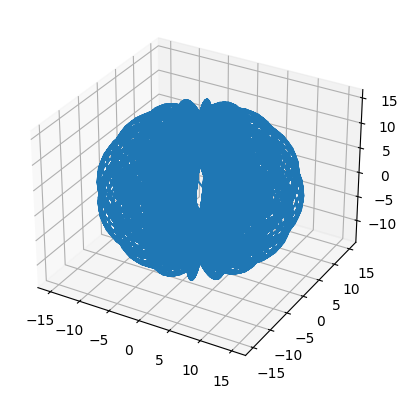

In [54]:
theta = np.pi/2
d = 0
a = 1
alpha = 0

points = []

l1 = joint_link(0, 1, 0, np.pi/2)
l2 = joint_link(0, 0, 5, 0)
l3 = joint_link(0, 0, 10, 0)

for theta1 in np.arange(-np.pi, np.pi, np.pi/8):
    for theta2 in np.arange(-np.pi, np.pi, np.pi/16):
        for theta3 in np.arange(-np.pi, np.pi, np.pi/16):
            x = l3(theta3)
            x = l2(theta2, x)
            x = l1(theta1, x)
            points.append(x.q)

points = np.array(points)

ax = plt.axes(projection ='3d')
ax.plot3D(points[:, 0], points[:, 1], points[:, 2])
plt.show()

In [32]:
def cubic(tg, qs, qg, t):
    a2 = 3*(qg - qs)/tg**2
    a3 = -2*(qg - qs)/tg**3
    return qs + a2*t**2 + a3*t**3 if t<tg else qg

In [59]:
import ipywidgets as widgets
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

l1 = joint_link(0, 1, 0, np.pi/2)
l2 = joint_link(0, 0, 10, 0)
l3 = joint_link(0, 0, 10, 0)

def theta (t):
    fig = plt.figure(figsize=(10,15))
    ax = plt.axes(projection ='3d')
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_zlim(-20, 20)
    
    pos = [[0, 0, 0]]
    
    x = l3(t*np.pi/128)
#     pos.append(x.q)

    x = l2(t*np.pi/64, x)
#     pos.append(x.q)

    x = l1(t*np.pi/32, x)
    pos.append(x.q)

    pos = np.array(pos)
    ax.plot3D(pos[:, 0], pos[:, 1], pos[:, 2],'red')
    plt.show()
    
widgets.interact(theta , t= widgets.Play(min=0,max =1000));

interactive(children=(Play(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact',))

In [50]:

l1 = joint_link(0, 1, 0, np.pi/2)
l2 = joint_link(0, 0, 10, 0)
l3 = joint_link(0, 0, 10, 0)

pos = []

x = l3(0)
pos.append(x.q)

x = l2(0, x)
pos.append(x.q)

x = l1(np.pi/2, x)
pos.append(x.q)

pos = np.array(pos)

In [51]:
pos

array([[1.00000000e+01, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+01, 0.00000000e+00, 0.00000000e+00],
       [3.55271368e-15, 2.00000000e+01, 1.00000000e+00]])

array([ 10.,  20., -20.])